### Import Modules

In [1]:
import numpy as np
import gvar as gv
import lsqfit
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import time

sys.path.append("../")
from fitter import data_loader as dl
from fitter import bootstrapper as bs
from fitter import fitter as fit

matplotlib.rcParams['figure.figsize'] = [10, 10]

In [2]:
reload(bs)
reload(dl)
reload(fit)

<module 'fitter.fitter' from '../fitter\fitter.pyc'>

### Specify fit parameters

In [32]:
p_dict = {
    'order_fit' : 1,
    'order_latt_spacing' : 2, # no order 1 term -- starts at 2
    'order_vol' : 1,
    'bs_N' : 20,  # if 0, use full list
    'fit_type' : 'xpt', #either 'mix' or 'xpt'
    
    'use_prior' : False,
    'save_prior' : False,
    'abbrs' : [u'a09m220', u'a09m310', u'a09m350', u'a09m400', u'a12m130',
           u'a12m220',  u'a12m220S', u'a12m310', u'a12m350',
           u'a12m400', u'a15m220', u'a15m310', u'a15m350',
           u'a15m400'],
    
    'make_plots' : True,
    'show_error_ellipses' : False,
    'show_bs_histograms' : False
}

### Do fit

In [33]:
t0 = time.time()

# Load data
data_loader = dl.data_loader()
fit_data = data_loader.get_fit_data()

# Get prior
prior = None
if p_dict['use_prior']:
    prior = data_loader.get_prior()

# Make bootstrapper
bootstrapper = bs.bootstrapper(fit_data, prior=prior, bs_N=p_dict['bs_N'], abbrs=p_dict['abbrs'],
                               order_fit=p_dict['order_fit'], order_vol=p_dict['order_vol'],
                               order_latt_spacing=p_dict['order_latt_spacing'],
                               fit_type=p_dict['fit_type'])


In [34]:
print bootstrapper

Making fits...
100% complete  Time (s):  2.71000003815
Compiling results...


Fitting to order 1 
 with lattice corrections O(2) 
 with volume corrections O(1) 
Fitted/[Experimental] values at physical point:

F_K / F_pi = 1.1779(37) [1.201(46)]

  Parameter    Result[0] / Prior[1]    Parameter    Result[0] / Prior[1]
-----------------------------------  -----------------------------------
  L_5_lam 0       ['0.000203 (27)']          1,1               0.0 (1.0)
          1               0.00 (50)    c_mpia2 0           ['2.36 (31)']
    c_a 0,0               0.12 (23)            1               2.00 (50)
        0,1               0.1 (1.1)    c_vol 0,0               0.26 (13)
        1,0               0.0 (1.0)          1,0               0.0 (1.0)
---
boot0 fit results:
Least Square Fit:
  chi2/dof [dof] = 1.1 [14]    Q = 0.37    logGBF = 48.295

Settings:
  svdcut/n = 1e-12/15    tol = (1e-08*,1e-10,1e-10)    (itns/time = 6/0.1)
  fitter = scipy_least_squares    method = trf



In [55]:
fit_data['a09m310'].keys()

[u'mq_s',
 u'z0_k',
 u'z0_ss',
 u'mss',
 u'mrs',
 u'a2DI',
 u'Fpi',
 u'mpi',
 u'MpiL',
 u'mres_s',
 u'mk',
 u'aw0',
 u'mru',
 u'mju',
 u'mres_l',
 u'Fss',
 u'alpha_s',
 u'mjs',
 u'FK',
 u'z0_pi',
 u'mq_l']

In [57]:
def test(self):
    for param in ['FK', 'Fpi', 'mpi', 'mk', 'mss', 'mru', 'mju']:
        print param, np.argsort([self.fit_data[abbr][param][0] for abbr in self.abbrs])
        
test(bootstrapper)

FK [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Fpi [ 0  1  2  3  4  6  5  7  8  9 10 11 12 13]
mpi [ 4  0  5  6  1  2 10  3  7  8 11  9 12 13]
mk [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
mss [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
mru [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
mju [ 0  1  4  2  5  6  3  7  8 10  9 11 12 13]


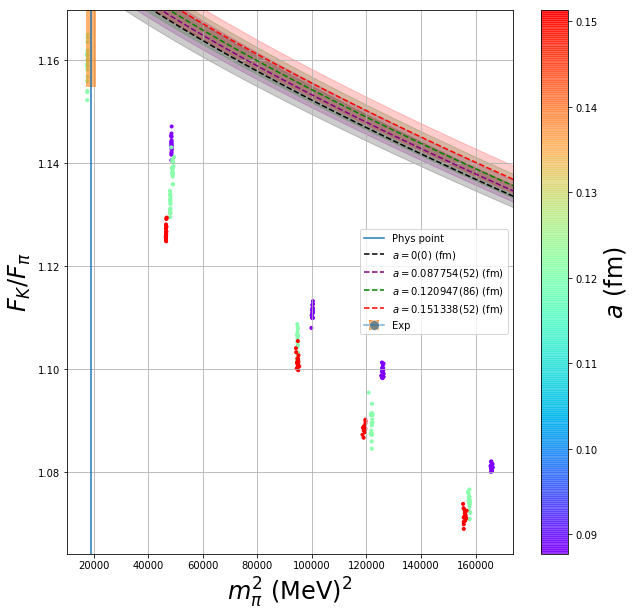

In [35]:
    def plot_parameters(self, xy_parameters, color_parameter=None,
                        xfcn=None, xlabel=None, yfcn=None, ylabel=None, show_fit=True):
        
        # used to convert to phys units
        hbar_c = 197.327
        
        if xlabel is None:
            xlabel = self._fmt_key_as_latex(xy_parameters[0])
        if ylabel is None:
            ylabel = self._fmt_key_as_latex(xy_parameters[1])

        if xfcn is None:
            xfcn = lambda x : 1 * x
        if yfcn is None:
            yfcn = lambda y : 1 * y

        plot_data = {}
        myfcn = [xfcn, yfcn]
        for j, parameter in enumerate(xy_parameters):
            if parameter in ['FK/Fpi', 'FK / Fpi']:
                plot_data[j] = {abbr :  myfcn[j](self.fit_data[abbr]['FK'] /self.fit_data[abbr]['Fpi']) for abbr in self.abbrs}
            elif parameter in ['mpi', 'mju', 'mru', 'mk', 'mrs', 'mss', 'FK', 'Fpi']:
                # Convert to physical units
                
                plot_data[j] = {}
                for abbr in self.abbrs:
                    plot_data[j][abbr] = myfcn[j](self.fit_data[abbr][parameter] *hbar_c / (self.fit_data[abbr]['a']))
            else:
                plot_data[j] = {abbr :  myfcn[j](self.fit_data[abbr][parameter]) for abbr in self.abbrs}

        
        if color_parameter is None:
            color_parameter = 'a'

        if color_parameter in ['a']:
            color_data = {abbr : np.repeat(self.fit_data[abbr]['a'][0], self.bs_N).ravel() for abbr in self.abbrs}
        elif color_parameter in ['L']:
            color_data = {abbr : np.repeat(gv.mean(self.fit_data[abbr][color_parameter]), self.bs_N).ravel() for abbr in self.abbrs}
        elif color_parameter == 'MpiL':
            color_data = {abbr : gv.mean(self.fit_data[abbr][color_parameter]).ravel() for abbr in self.abbrs}
        else:
            color_data = {abbr : gv.mean(self.fit_data[abbr][color_parameter]).ravel() for abbr in self.abbrs}

        # Color by lattice spacing/length
        cmap = matplotlib.cm.get_cmap('rainbow')
        min_max = lambda x : [np.min(x), np.max(x)]
        minimum, maximum = min_max(np.concatenate([gv.mean(color_data[abbr]) for abbr in self.abbrs]))
        norm = matplotlib.colors.Normalize(vmin=minimum, vmax=maximum)

        # Get scatter plot & color data
        x = np.zeros(self.bs_N * len(self.abbrs))
        y = np.zeros(self.bs_N * len(self.abbrs))
        z = np.zeros(self.bs_N * len(self.abbrs))
        for j, abbr in enumerate(self.abbrs):
            x[j*self.bs_N:(j+1)*self.bs_N] = gv.mean(plot_data[0][abbr])
            y[j*self.bs_N:(j+1)*self.bs_N] = gv.mean(plot_data[1][abbr])
            z[j*self.bs_N:(j+1)*self.bs_N] = gv.mean(color_data[abbr])

        sc = plt.scatter(x, y, c=z, vmin=minimum, vmax=maximum,
                         cmap=cmap, rasterized=True, marker=".", alpha=100.0/self.bs_N)

        if ((show_fit)
                and (xy_parameters[1] in ['FK/Fpi', 'FK / Fpi'])
                and (xy_parameters[0] in['mpi', 'mju', 'mru', 'mk', 'mrs', 'mss', 'FK', 'Fpi'])):

            plt.axvline(gv.mean(xfcn(self.get_phys_point_data(xy_parameters[0]))), label='Phys point')
            y_phys = self.get_phys_point_data('FK/Fpi')
            plt.errorbar(x=gv.mean(xfcn(self.get_phys_point_data(xy_parameters[0]))), xerr=0,
                         y=gv.mean(y_phys), yerr=gv.sdev(y_phys), label='Exp',
                        color='C0', marker='o', capsize=0.0, mec='white', ms=10.0, alpha=0.6,
                             ecolor='C1', elinewidth=10.0)

            colors = ['black', 'purple', 'green', 'red']
            lattice_spacings = np.unique(self._make_fit_data(0)['a'])
            for j, a in enumerate(np.append([gv.gvar('0(0)')], lattice_spacings)):
                
                minimum = np.nanmin([np.nanmin(
                    self.fit_data[abbr][xy_parameters[0]] *hbar_c / (self.fit_data[abbr]['a'])
                ) for abbr in self.abbrs])
                maximum = np.nanmax([np.nanmax(
                    self.fit_data[abbr][xy_parameters[0]] *hbar_c / (self.fit_data[abbr]['a'])
                ) for abbr in self.abbrs])
                minimum = gv.mean(minimum)
                maximum = gv.mean(maximum)
                delta = maximum - minimum

                x = np.linspace(np.max((minimum - 0.05*delta, 0)), maximum + 0.05*delta)
                


                # Get phys point data, substituting x-data and current 'a' in loop
                prepped_data = self.get_phys_point_data()
                prepped_data[xy_parameters[0]] = x
                prepped_data['a'] = a

                y = self.fk_fpi_fit_fcn(fit_data=prepped_data)

                pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
                plt.plot(xfcn(x), pm(y, 0), '--', color=colors[j], label='$a=$%s (fm)'%(str(a)), rasterized=True)
                plt.fill_between(xfcn(x), pm(y, -1), pm(y, 1), alpha=0.20, color=colors[j], rasterized=True)

            plt.legend()

        # Plot labels
        plt.grid()
        plt.xlabel(xlabel, fontsize = 24)
        plt.ylabel(ylabel, fontsize = 24)

        # Format colorbar
        color_bar = plt.colorbar(sc)
        color_bar.set_alpha(0.8)
        color_bar.draw_all()
        color_bar.set_label(self._fmt_key_as_latex(color_parameter), fontsize = 24)

        # Set xlim, ylim -- only works if xy_parameters[i] is a vector, not a scalar
        min_max = lambda x : [np.min(x), np.max(x)]
        try:
            xmin, xmax = min_max(np.concatenate([gv.mean(plot_data[0][abbr]) for abbr in self.abbrs]))
            ymin, ymax = min_max(np.concatenate([gv.mean(plot_data[1][abbr]) for abbr in self.abbrs]))
            xdelta = xmax - xmin
            ydelta = ymax - ymin
            plt.xlim(xmin-0.05*xdelta, xmax+0.05*xdelta) #xmin-0.05*xdelta
            plt.ylim(ymin-0.05*ydelta, ymax+0.05*ydelta)
        except ValueError:
            pass

        fig = plt.gcf()
        plt.close()
        return fig
    
    squared = lambda x : x**2
    plot_parameters(bootstrapper, xy_parameters=['mpi', 'FK/Fpi'],
                    xfcn=squared, xlabel='$m_\pi^2$ (MeV)$^2$', color_parameter='a', show_fit=True)

In [36]:
bootstrapper.abbrs[10]

u'a15m220'

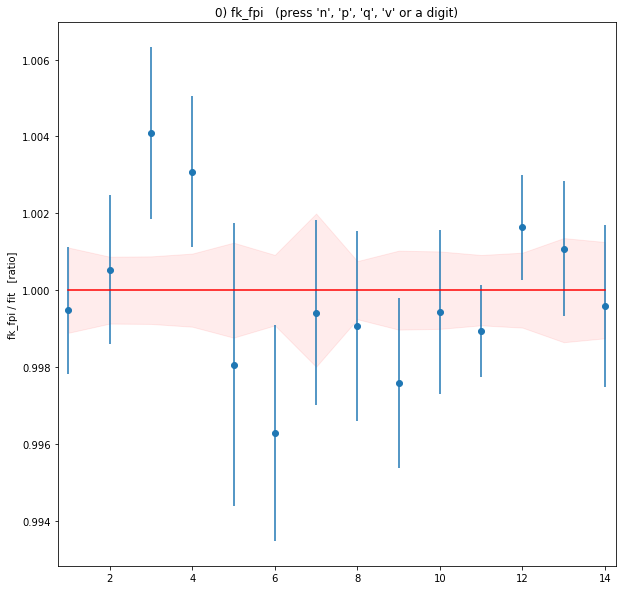

In [41]:
bootstrapper.fits[0].show_plots()

In [92]:
temp = [(4*np.pi)**2 *fit_data[abbr]['FK'][0]*fit_data[abbr]['Fpi'][0] for abbr in fit_data.keys()]

In [93]:
[np.min(temp), np.max(temp)]

[0.33142743488829551, 1.0659066704236386]

In [322]:
bootstrapper.create_prior_from_fit()

ValueError: Argument shapes mismatched: (1L,) ()

In [ ]:
t0 = time.time()

# Load data
data_loader = dl.data_loader()
fit_data = data_loader.get_fit_data()

# Get prior
prior = None
if p_dict['use_prior']:
    prior = data_loader.get_prior()

# Make bootstrapper
bootstrapper = bs.bootstrapper(fit_data, prior=prior, order=p_dict['order'], bs_N=p_dict['bs_N'], abbrs=p_dict['abbrs'])

if p_dict['make_plots']:
    data_loader.save_plots(bootstrapper.make_plots(
        show_error_ellipses=p_dict['show_error_ellipses'], show_bootstrap_histograms=p_dict['show_bs_histograms']))
else:
    print bootstrapper
    
if p_dict['save_prior']:
    print 'Saving prior...'
    data_loader.save_prior(bootstrapper.create_prior_from_fit())
    
    
t1 = time.time()

print "\nTotal time (s): ", t1 - t0, "\n"

Making fits...
100% complete  Time (s):  2.39598703384
Getting bs fit parameters...
38% complete 